In [49]:
!pip3 -q install gensim
!pip3 -q install pyspellchecker

     |████████████████████████████████| 2.7 MB 15.1 MB/s 


In [231]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import gensim.downloader
from spellchecker import SpellChecker
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
with open('/content/drive/MyDrive/NLP_proj/words.pkl', 'rb') as f:
    words = pickle.load(f)

In [12]:
with open('/content/drive/MyDrive/NLP_proj/words_vectors.pkl', 'rb') as f:
    words_vectors = np.asarray(pickle.load(f))

In [13]:
len(words)

13979

In [14]:
words_vectors.shape

(13979, 300)

In [33]:
agglomerative = AgglomerativeClustering(
    n_clusters=None,
    affinity='cosine',
    linkage='complete',
    distance_threshold=0.6
)

In [34]:
agglomerative.fit(words_vectors)

AgglomerativeClustering(affinity='cosine', distance_threshold=0.6,
                        linkage='complete', n_clusters=None)

In [39]:
len(Counter(agglomerative.labels_).keys())

5147

In [40]:
np.mean(list(Counter(agglomerative.labels_).values()))

2.715951039440451

In [35]:
Counter(agglomerative.labels_)

Counter({474: 13,
         979: 3,
         626: 16,
         641: 6,
         4312: 4,
         4988: 1,
         1613: 2,
         1007: 4,
         1692: 2,
         638: 3,
         1134: 2,
         2171: 4,
         1500: 4,
         803: 3,
         1580: 2,
         316: 3,
         24: 6,
         1054: 4,
         3186: 2,
         2808: 2,
         3459: 2,
         1755: 6,
         987: 3,
         2148: 2,
         3804: 2,
         1417: 2,
         3674: 1,
         2974: 2,
         4981: 1,
         797: 3,
         4156: 3,
         1569: 3,
         4122: 2,
         610: 2,
         4062: 2,
         383: 2,
         2191: 2,
         4218: 3,
         251: 8,
         1582: 3,
         2530: 3,
         2605: 2,
         1298: 3,
         2715: 1,
         2097: 6,
         341: 10,
         360: 4,
         3108: 4,
         1160: 2,
         2573: 2,
         2317: 4,
         242: 4,
         3536: 4,
         2415: 2,
         4827: 1,
         3508: 4,
      

In [83]:
labels = dict(zip(words, agglomerative.labels_))

# BoG + Word2Vec

In [46]:
train_df = pd.read_csv('/content/drive/MyDrive/NLP_proj/NLP_train.csv')

In [51]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [52]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [261]:
def preprocess_sentecnce(sentence, spell_checker, tokenizer, lemmatizer, stop_words, labels):
    sentence = sentence.replace(r'\n', ' ')
    sentence = re.sub(r'\d+', '', sentence) # remove numbers
    tokens = tokenizer.tokenize(sentence) # split a sentence into tokens
    
    filtered_tokens = []
    for token in tokens:
        
        if token.lower() not in stop_words:
            token = lemmatizer.lemmatize(token).lower()
            if token not in list(labels.keys()):
                token = spell_checker.correction(token)
        
            token = str(labels.get(token, token)) #key: token, default: token

            filtered_tokens.append(token)
            
    return '#'.join(filtered_tokens) # form a string from obtained tokens

In [122]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+|[0-9]+)')
spell_checker = SpellChecker()

In [123]:
train_df['filtered_tokens'] = train_df['Comment'].apply(
    lambda row: preprocess_sentecnce(
        row, 
        spell_checker,
        tokenizer, 
        lemmatizer, 
        stop_words,
        labels
        )
    )

In [126]:
len(np.unique('#'.join(train_df['filtered_tokens'].tolist()).split('#')))

6265

In [138]:
tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)

In [139]:
features = tfidf.fit_transform(train_df['filtered_tokens'])

In [153]:
features = features.todense()

In [154]:
features.shape

(8695, 4730)

# Classification

In [155]:
ground_truth = train_df['Topic']

In [160]:
x_train, x_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.33, random_state=2000)

### SVM

In [161]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=2000))

In [162]:
svm.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=2000))])

In [164]:
svm_accuracy = classifier.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [168]:
svm_accuracy

0.6313588850174217

### Perceptron

In [225]:
perceptron = Perceptron(
    penalty='l2',
    early_stopping=True,
    random_state=2000
)

In [226]:
perceptron.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Perceptron(early_stopping=True, penalty='l2', random_state=2000)

In [227]:
perceptron_accuracy = perceptron.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [228]:
perceptron_accuracy

0.6066202090592334

### MLP (Multi Layer Perceptron)

In [220]:
mlp = MLPClassifier(
    # 4730 --> 128 --> 3
    hidden_layer_sizes=(128,),
    early_stopping=True,
    random_state=2000 
)

In [221]:
mlp.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,), random_state=2000)

In [222]:
mlp_accuracy = mlp.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [223]:
mlp_accuracy

0.7080139372822299

# Results comparison

In [229]:
algortihhms = [
    'SVM',
    'Perceptron',
    'MLP'
]

In [230]:
algortihhms_accuracies = [
    svm_accuracy,
    perceptron_accuracy,
    mlp_accuracy
]

In [242]:
print('The comparison of obtained accuracies:')
for algo, acc in list(zip(algortihhms, algortihhms_accuracies)):
    print(f'{algo:10}:\t{acc*100:.2f}%')

The comparison of obtained accuracies:
SVM       :	63.14%
Perceptron:	60.66%
MLP       :	70.80%




| Algorithm | Accuracy |
| --- | --- |
| SVM | 63.14% |
| Perceptron | 60.66% |
| MLP | **70.80%** |

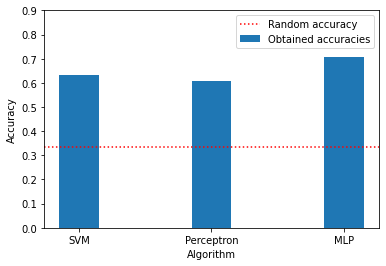

In [258]:
plt.bar(
    algortihhms, 
    algortihhms_accuracies,
    width=0.3,
    label='Obtained accuracies'
)

plt.axhline(
    y=1/3, 
    color='r', 
    linestyle='dotted',
    label='Random accuracy'
)

plt.ylim([0,0.9])
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.legend()